In [1]:
import os, sys
import numpy as np
import pandas as pd
import copy
from fancyimpute import KNN    

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20,15]
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import seaborn as sns

plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid' : False})
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tqdm import tqdm_notebook
from tqdm import tqdm

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, classification_report
plt.style.use('seaborn')

In [7]:
'set resources folder'
resources_dir = "/Volumes/broad_regevtmp/dsilverb/Glioma_scRRBS/classifier_for_github/data/"
assert os.path.isdir(resources_dir)
figures_dir = "/Volumes/broad_regevtmp/dsilverb/Glioma_scRRBS/classifier_for_github/figures/"
assert os.path.isdir(figures_dir)


## Functions

In [8]:
def mark_non_malignant(df_sc, tumor_type):
    classification_dir = resources_dir + "/"
    non_malignant = pd.read_table(classification_dir + tumor_type + "_normal.txt", sep = "\t", header=None)
    macrophages = pd.read_table(classification_dir + tumor_type + "_macrophages.txt", sep = "\t", header=None)
    non_malignant['non_malignant'] = 'non_malignant'
    macrophages['macrophages'] = 'macrophages'

    non_malignant.columns = ["non_malignant_RRBS","non_malignant"]
    macrophages.columns = ["macrophages_RRBS","macrophages"]

    non_malignant['non_malignant_RRBS'] = non_malignant['non_malignant_RRBS'].str.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov")
    macrophages['macrophages_RRBS'] = macrophages['macrophages_RRBS'].str.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov")


    'mark as marcophages/normal'
    df_sc[tumor_type + '_macrophage'] = [filename in list(macrophages['macrophages_RRBS']) for filename in df_sc['qc_filename']]
    df_sc[tumor_type + '_normal'] = [filename in list(non_malignant['non_malignant_RRBS']) for filename in df_sc['qc_filename']]

    return (df_sc)

In [9]:
# Label meaning:
# IDHmut-non-codel: Astrocytoma (LGm1 or LGm2)
# IDHmut-codel: Oligodendroglioma (LGm2 or LGm3)
classifier_dict = {
    'Non malignant':'normal',
    'oligodendrocytes':'normal',
    'macrophages':'normal',
    'MGH211':'WT', 
    'MGH105':'WT', 
    'MGH105macrophage':'normal', 'MGH107':'IDHmut-non-codel', 
    'MGH115':'WT', 'MGH120':'IDHmut-codel', 
    'MGH121':'WT',  'MGH122':'WT', 'MGH124':'WT', 
    'MGH129':'WT', 'MGH135':'IDHmut-codel', 'MGH137':'IDHmut-non-codel', 
    'MGH170':'IDHmut-codel', 'MGH45':'IDHmut-non-codel', 'MGH64':'IDHmut-non-codel',
    'MGH143' : "WT",
    'MGH142' : "IDHmut-codel", 
    'MGH208' : 'IDHmut-codel', 
    'MGH201' : "IDHmut-non-codel", 
}


def get_label_from_filename(filename, label='tumor'):
    """
        Dana's pipeline for getting tumor label 
        from sc filename. 
        `label` is either `tumor` or `y`
    """
    filename = filename.replace('GBM_', "")
    filename = filename.replace('IDH_', "")
    filename = filename.replace('-', "_")
    filename = filename.replace('MGH121_',"MGH121")
    filename = filename.replace('MGH105C_P8',"MGH105Cmacrophage")
    filename = filename.replace('MGH105A',"MGH105")
    filename = filename.replace('MGH105B',"MGH105")
    filename = filename.replace('MGH105C',"MGH105")
    filename = filename.replace('MGH105D',"MGH105")
    filename = filename.replace('MGH121Plate1',"MGH121")
    filename = filename.replace('MGH121Plate2',"MGH121")
    filename = filename.replace('MGH121Plate3',"MGH121")
    filename = filename.replace('MGH121Plate4',"MGH121")
    
    
    tumor = filename.split('_')[0]
    y = classifier_dict[tumor]
    if label == 'tumor':
        return tumor
    elif label == 'y':
        return y
    else:
        raise NotImplementedError

## Parameters

In [10]:
tiles = '1000'

In [11]:
'QC filters'
MIN_CELLS_PER_WINDOW = 10
NUM_CPGS_IN_WINDOW = 5
MIN_BULK_SAMPLES_PER_PROBE = 20

## Build a classifier

In [12]:
'prepare the TCGA bulk samples for training'
# Read classification
bulk_classes = pd.read_table(resources_dir + "TCGA_classification.csv", sep = ",", index_col = 0, header = 0)

# Read training data
training_data = pd.read_table(resources_dir + "/bulk_centered_Tiles"+tiles+"_HG38.csv", sep = "\t", index_col = 0)

# Filter to 1,300 CpGs in the TCGA signature
LGm_probes = pd.read_table(resources_dir + "1300_pan_glioma_tumor_specific.csv", sep = ",", index_col = 0)
LGm_probes = LGm_probes['x'].values.flatten()
training_data = training_data[training_data['Composite.Element.REF'].isin(LGm_probes)]


In [13]:
'Filter bulk data'
training_data = training_data[(training_data.isnull().sum(axis = 1) <= MIN_BULK_SAMPLES_PER_PROBE)]

In [18]:
training_data.head()

,Composite.Element.REF,Gene_Symbol,Chromosome,Genomic_Coordinate,TCGA.CS.4941,TCGA.CS.4942,TCGA.CS.4943,TCGA.CS.4944,TCGA.CS.5390,TCGA.CS.5393,...,TCGA.32.4719,TCGA.41.2572,TCGA.41.3393,TCGA.41.3915,TCGA.41.4097,loci,hg19_loci,left_coordinate_window,right_coordinate_window,rrbs_group
3,cg00003994,MEOX2,7,15686237,0.095928,0.066895,0.398218,0.271551,0.766664,0.171576,...,0.056499,0.041779,0.029960,0.031654,0.054829,7:15686237,7:15725862,15686130,15687130,15686130
28,cg00027083,EPB41L3,18,5543802,0.507867,0.016572,0.016379,0.014542,0.012703,0.014216,...,0.792925,0.786483,0.486311,0.140576,0.324858,18:5543802,18:5543801,5543302,5544302,5543302
51,cg00047050,CUL5,11,108008705,0.073251,0.041110,0.389032,0.104821,0.478633,0.055231,...,0.043401,0.027273,0.025683,0.034179,0.058622,11:108008705,11:107879431,108008190,108009190,108008190
60,cg00056767,CCDC122;C13orf31,13,43879047,0.076830,0.437488,0.837389,0.124155,0.763647,0.435180,...,0.028327,0.101514,0.034523,0.180295,0.483697,13:43879047,13:44453183,43878547,43879547,43878547
84,cg00076645,UBTD2,5,172284558,0.041970,0.051543,0.576727,0.057447,0.108024,0.052842,...,0.016372,0.017575,0.018214,0.015662,0.018818,5:172284558,5:171711562,172284058,172285058,172284058


In [14]:
'prepare the sc data - create windows which are the average of CpGs methylation'
# Read sc data
sc_data = pd.read_table(resources_dir + "/sc_centered_Tiles"+tiles+"_filtered_to_bulk.txt", sep = "\t", index_col = 0, encoding = "ISO-8859-1", header = 0)

# Read samples added during revision/after creating the classifer 
sc_data_additional_samples = pd.read_table(resources_dir + "/sc_centered_Tiles"+tiles+"_filtered_to_bulk_MGH211.txt", sep = "\t", index_col = 0, encoding = "ISO-8859-1", header = 0)
sc_data_revision_samples = pd.read_table(resources_dir + "/all_var_sc_tiles_L1000_mean_newsamples.csv", sep = "\t", index_col = 0, encoding = "ISO-8859-1", header = 0)
sc_data = pd.concat([sc_data, sc_data_additional_samples,sc_data_revision_samples])
sc_data = pd.concat([sc_data, sc_data_additional_samples])

In [15]:
'Binarize the CpGs' 

# quality control: remove all the CpGs for which the reads are between 0.9 and 0.1 
sc_data = sc_data.loc[((sc_data['percentage'] >= 0.9) | (sc_data['percentage'] <= 0.1))]

# Binarize the CpGs, below 0.1 reads methylated is considered unmethylted CpG, above 0.9 is considered methylated CpG
sc_data['CpG_methylated'] = 0
sc_data.loc[sc_data['percentage'] >= 0.9,'CpG_methylated'] = 1
sc_data = sc_data[['CpG_methylated','rrbs_group','filename']]

In [16]:
'QC: Filetr cells'

#read qc for each single cell
cells_qc = pd.read_table(resources_dir + "/allQC_POST_filtered_50K_10232020.csv", sep = ",")
sc_data_filename = cells_qc['Cell']
sc_data_filename = [filename.replace('-',"_") for filename in sc_data_filename]
cells_qc['Cell'] = sc_data_filename
cells_qc.index = cells_qc['Cell']
dict_cell_Total_Reads =  cells_qc['Total_Reads'].to_dict()
dict_cell_CpG_Sites =  cells_qc['CpG_Sites'].to_dict()
dict_cell_CG_conversion_rate =  cells_qc['CG_conversion_rate'].to_dict()

# fix filenames
sc_data_filename = sc_data['filename']
sc_data_filename = [filename.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov") for filename in sc_data_filename]
sc_data_filename = [filename.rstrip(".R1.fastq_bismark_bt2_pe.bismark.tsv") for filename in sc_data_filename]
sc_data_filename = [filename.replace('__001',"") for filename in sc_data_filename]
sc_data_filename = [filename.replace('_.',".") for filename in sc_data_filename]
sc_data_filename = [filename.replace('-',"_") for filename in sc_data_filename]
sc_data_filename = [filename.replace('MGH115_CD45',"MGH115") for filename in sc_data_filename]
sc_data['corrected_filename'] = sc_data_filename

In [17]:
'Filter cells with less than 50,000 CpG sites'
sc_data_cell_CpG_Sites = sc_data['corrected_filename'].map(dict_cell_CpG_Sites)
sc_data = sc_data.loc[(sc_data_cell_CpG_Sites >= 0.05)]

In [28]:
# number of CpGs per window
#plt.hist(sc_data.groupby(['rrbs_group','filename']).count())

In [29]:
'Filter to minimum number of CpGs in a window'
sc_data_cvount_CpG_per_window = sc_data.groupby(['rrbs_group','filename']).count().reset_index()
rrbs_groups_past_qc = sc_data_cvount_CpG_per_window.loc[sc_data_cvount_CpG_per_window['CpG_methylated'] >= NUM_CPGS_IN_WINDOW]['rrbs_group']
sc_data = sc_data.loc[sc_data['rrbs_group'].isin(rrbs_groups_past_qc)]

In [19]:
'Filter to minimum number of cells per window'
sc_data_count_cells_per_window = sc_data[['rrbs_group','corrected_filename']].drop_duplicates().groupby('rrbs_group').count().reset_index()

In [20]:
#plt.hist(sc_data_count_cells_per_window[sc_data_count_cells_per_window['rrbs_group'].isin(rrbs_windows)]['corrected_filename'])

In [21]:
rrbs_windows_past_qc = sc_data_count_cells_per_window.loc[(sc_data_count_cells_per_window['corrected_filename'] >= MIN_CELLS_PER_WINDOW)]['rrbs_group']
sc_data = sc_data.loc[sc_data['rrbs_group'].isin(rrbs_windows_past_qc)]


In [22]:
#plt.hist(sc_data_cvount_CpG_per_window.loc[sc_data_cvount_CpG_per_window['rrbs_group'].isin(rrbs_windows)]['CpG_methylated'], range=[0, 30])

In [23]:
'create sc rrbs window - mean methylation of CpGs in the window'
df_sc = sc_data.pivot_table(values='CpG_methylated', index='corrected_filename', columns='rrbs_group', aggfunc='mean') 

# match the bulk scale going from 0 to 100
df_sc = df_sc *100

In [24]:
df_sc.head()

rrbs_group,76573,87142,124135,152194,172900,176704,179663,195978,196724,213080,...,242523663,242524879,244460983,244864392,246564925,247111542,247112845,247417615,247856779,247936438
corrected_filename,,,,,,,,,,,,,,,,,,,,,
GBM_MGH105C_A1_S1_L008.ACAACC,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,...,NaN,0.0,14.285714,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
GBM_MGH105C_A1_S1_L008.ACAGAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,87.5,25.0
GBM_MGH105C_A1_S1_L008.ACTCAC,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,100.0,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBM_MGH105C_A1_S1_L008.AGAAGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.000000,0.0,NaN,9.090909,NaN,100.0,NaN,NaN
GBM_MGH105C_A1_S1_L008.AGGATG,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


In [25]:
'Filter both bulk and sc to the same rrbs'
rrbs_windows = list(set(training_data['rrbs_group']).intersection(df_sc.columns))
rrbs_windows = np.unique(rrbs_windows)
training_data = training_data[training_data['rrbs_group'].isin(rrbs_windows)]

In [26]:
'pivot the bulk training data to sample per methylation window'
training_data = training_data.reset_index()
rrbs_groups = training_data['rrbs_group']
tumor_names = [i for i in training_data.columns  if i.startswith('TCGA')]
tumor_names.append('rrbs_group')

# compute mean DNA methylation per window
training_data_windows = training_data[tumor_names]
training_data_windows = training_data_windows.groupby('rrbs_group').mean()
training_data_windows = training_data_windows.T

In [27]:
'Map training cases to LGm class'
# prepare a dictionary from case name to status
IDH_class = bulk_classes['Pan-Glioma DNA Methylation Cluster']#'IDH/codel subtype']#'IDH status']'IDH/codel subtype']
class_dict = dict(zip(bulk_classes.index,IDH_class))

# map LGm class to each training sample
training_data_windows = training_data_windows.reset_index()
training_data_windows = training_data_windows.rename(columns={'index':'case'})
training_data_windows['case'] = training_data_windows['case'].str.replace('.','-')
training_data_windows['y'] = training_data_windows['case'].map(class_dict)

training_data_windows = training_data_windows[(~(training_data_windows[['y']].isnull().values.flatten()))]
training_data_windows.index = training_data_windows['case']
training_data_windows = training_data_windows.drop(columns = ['case'])

# sort by class
df_bulk = training_data_windows
df_bulk = df_bulk.sort_values('y', axis=0) # sort values by meth class

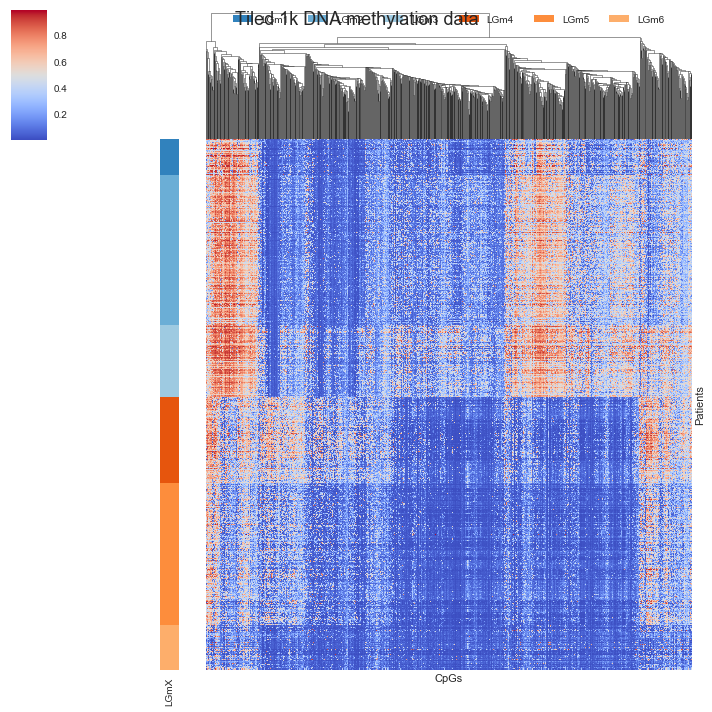

In [28]:
# Add color class to meth class
lgm_classes = df_bulk.y.unique()
colors = plt.get_cmap('tab20c').colors
colors = colors[0:3] + colors[4:7]
mapper = {lgm_class: color for lgm_class, color in zip(lgm_classes, colors)}
df_bulk['LGmX'] = df_bulk.y.map(mapper)

# Convert numerical type to float
df_data = df_bulk.drop(['LGmX', 'y'], axis=1).astype('f')
assert np.sum(np.sum(df_data.isnull()).values) == 0

# Visualize
cg = sns.clustermap(df_data, 
                    cmap='coolwarm', 
                    row_cluster=False,
                    row_colors=df_bulk.LGmX,
                    linewidths=0, 
                    xticklabels=False, 
                    yticklabels=False,
);

ax = cg.ax_heatmap;
ax.set_xlabel('CpGs');
ax.set_ylabel('Patients');
plt.suptitle('Tiled 1k DNA methylation data');

# cg.ax_col_dendrogram.set_visible(True)
cg.ax_row_dendrogram.set_xlim([0, .1])
cg.ax_row_dendrogram.set_ylim([0, .1])
cg.ax_row_dendrogram.set_axis_off()
# cg.cax.set_position([.15, .2, .03, .45])
for color, label in zip(df_bulk.LGmX.unique(), df_bulk.y.unique()):
    cg.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
cg.ax_col_dendrogram.legend(loc="upper center", ncol=6);
cg_bulk = cg;

In [29]:
'z-score tiled data'
def feature_norm(data_df, orig_df, title=None, return_cg=True, to_plot=False):
    ss = StandardScaler()
    X_data = ss.fit_transform(data_df)
    colors = orig_df.LGmX.values
    Y_data = orig_df.y.values
    
    if (not to_plot):
        return  X_data, Y_data
    else:
        # visualize
        cg = sns.clustermap(X_data,
                   cmap='coolwarm', 
                   row_cluster=False,
                   row_colors=colors,
                   robust=True,
        );
        ax = cg.ax_heatmap;
        ax.set_xlabel('CpGs');
        ax.set_ylabel('Patients');
        for color, label in zip(orig_df.LGmX.unique(), orig_df.y.unique()):
            cg.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
        cg.ax_col_dendrogram.legend(loc="upper center", ncol=6);
        if title is not None:
            plt.suptitle(title);
        else:
            plt.suptitle('z-scored data');
        if return_cg is True:
            return X_data, Y_data, cg
        else:
            return X_data, Y_data

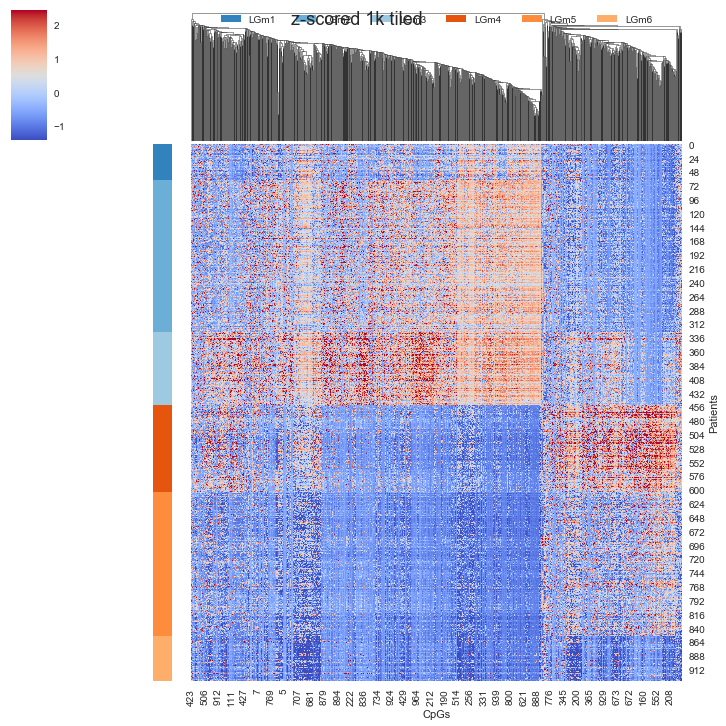

In [30]:
'z-score tiled and get reordered matrix'
X_1k, Y_1k, cg = feature_norm(df_data, df_bulk, title='z-scored 1k tiled', return_cg=True, to_plot=True) 

In [31]:
'train a calssifier'

'Shuffle data and do stratified splitting'
X = X_1k
Y = Y_1k
from sklearn.model_selection import train_test_split
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, 
                                              shuffle=True, 
                                              test_size=.2, 
                                              stratify=Y,
                                             )
Y_trn = list(Y_trn)
Y_tst = list(Y_tst)
classes, counts = np.unique(Y_tst, return_counts=True)
counts

C = 0.1
logisticRegr = LogisticRegression(
                penalty='l2',  # ideally regularize with l1
                multi_class='multinomial',  # cross-entropy loss function I hope.
                solver='lbfgs',
                C=C,
                tol=0.01,  # ensure convergence of saga
                class_weight='balanced')



logisticRegr.fit(X_trn, Y_trn)
Y_prd = logisticRegr.predict(X_tst)
res = classification_report(
    Y_tst,
    Y_prd,
)
print(res)

              precision    recall  f1-score   support

        LGm1       0.91      0.77      0.83        13
        LGm2       0.93      0.94      0.93        53
        LGm3       0.93      0.96      0.94        26
        LGm4       1.00      0.83      0.91        30
        LGm5       0.91      0.96      0.93        50
        LGm6       0.88      1.00      0.94        15

    accuracy                           0.93       187
   macro avg       0.92      0.91      0.91       187
weighted avg       0.93      0.93      0.92       187



In [32]:
'prepare a classifier using the whole training data (since we are testing on sc)'
Y = df_bulk['y']
df_data = df_bulk.drop(['LGmX', 'y'], axis=1).astype('f')
bulk_zscore = StandardScaler().fit_transform(df_data[rrbs_windows])
C = 0.1
logisticRegr = LogisticRegression(
                penalty='l2',  # ideally regularize with l1
                multi_class='multinomial',  # cross-entropy loss function I hope.
                solver='lbfgs',
                C=C,
                tol=0.01,  # ensure convergence of saga
                class_weight='balanced',
                )
logisticRegr.fit(bulk_zscore, Y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.01,
                   verbose=0, warm_start=False)

## Test classifier on single cell pseudo bulk

In [33]:
'add qc information to the sc'
df_sc['qc_filename'] = df_sc.index
df_sc['CG_conversion_rate'] = df_sc['qc_filename'].map(dict_cell_CG_conversion_rate)
df_sc['Total_Reads'] = df_sc['qc_filename'].map(dict_cell_Total_Reads)
df_sc['CpG_Sites'] = df_sc['qc_filename'].map(dict_cell_CpG_Sites)

In [34]:
'mark non malignant cells'
# mark non malignant cells
df_sc = mark_non_malignant(df_sc, 'GBM')
df_sc = mark_non_malignant(df_sc, 'IDH')
df_sc['oligodendrocytes'] = df_sc[['GBM_normal','IDH_normal']].any(axis = 1)
df_sc['macrophages'] = df_sc[['GBM_macrophage','IDH_macrophage']].any(axis = 1)
df_sc['non_malignant'] = df_sc[['GBM_normal','GBM_macrophage','IDH_normal','IDH_macrophage']].any(axis = 1)

In [35]:
'reformat the filename for the sc'
sc_filename = df_sc['qc_filename']
filenames = [filename.rstrip(".R1.fastq_bismark_bt2_pe.bismark.tsv") for filename in sc_filename]
filenames = [filename.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov") for filename in filenames]
filenames = [filename.replace('GBM_',"") for filename in filenames]
filenames = [filename.replace('IDH_',"") for filename in filenames]
filenames = [filename.replace('-',"_") for filename in filenames]
filenames = [filename.replace('MGH121_',"MGH121") for filename in filenames]
filenames = [filename.replace('MGH105C_P8',"MGH105Cmacrophage") for filename in filenames]
df_sc['filename'] = filenames

In [36]:
'Filter to tumors of interest (default is all tumors in the study)'
df_sc['tumor'] = df_sc['filename'].apply(get_label_from_filename, label='tumor')  
df_sc['y'] = df_sc['filename'].apply(get_label_from_filename, label='y')
df_sc = df_sc[df_sc['tumor'].isin(['MGH105', 'MGH105macrophage', 'MGH107', 'MGH115', 
       'MGH121', 'MGH122', 'MGH124', 'MGH129', 'MGH135',
       'MGH211', 'MGH45', 'MGH64',"MGH142","MGH208","MGH201"])]

In [37]:
'Create a data set containing non malignant cells and one not containing it'
df_sc_w_nonmalignant = copy.deepcopy(df_sc)

In [38]:
'group non_malignant cells in their own tumor'
df_sc_w_nonmalignant['original_tumor'] = df_sc_w_nonmalignant['tumor']
df_sc_w_nonmalignant['original_tumor_sep_to_CD45'] = df_sc_w_nonmalignant['original_tumor']
df_sc_w_nonmalignant['original_tumor'] = df_sc_w_nonmalignant['original_tumor'].replace("MGH105macrophage","MGH105")

df_sc_w_nonmalignant.loc[df_sc_w_nonmalignant['oligodendrocytes'] == True, 'tumor'] = "oligodendrocytes"
df_sc_w_nonmalignant.loc[df_sc_w_nonmalignant['macrophages'] == True, 'tumor'] = "macrophages"

# One cell which is clearly a macrophage
df_sc_w_nonmalignant.loc[df_sc_w_nonmalignant['tumor'] == "MGH105macrophage","tumor"] = "macrophages"

In [39]:
'standard scaling for the sc data'
X_data_w_nonmalignant = df_sc_w_nonmalignant[rrbs_windows].to_numpy()
X_ss_w_nonmalignant = X_data_w_nonmalignant
#X_ss_w_nonmalignant = StandardScaler().fit_transform(X_data_w_nonmalignant)

### Predictong LGm classes for single cell Pseudo bulk

In [40]:
'build pseudo bulk data/labels for cv'
X_pb_w_nonmalignant = []
Y_pb_w_nonmalignant = []
X_partition_w_nonmalignant = [] 
for tumor in df_sc_w_nonmalignant.tumor.unique():
    mask = df_sc_w_nonmalignant.tumor == tumor
    mask = mask.values
    X_tumor_w_nonmalignant = X_ss_w_nonmalignant[mask]
    X_partition_w_nonmalignant.append(X_tumor_w_nonmalignant)
    X_pb_w_nonmalignant.append(np.nanmean(X_tumor_w_nonmalignant, axis=0))
    Y_pb_w_nonmalignant.append(tumor)
X_pb_w_nonmalignant = np.asarray(X_pb_w_nonmalignant)
X_pb_w_nonmalignant.shape, X_pb_w_nonmalignant.dtype, len(X_pb_w_nonmalignant)

((16, 996), dtype('float64'), 16)

In [41]:
X_pb_w_nonmalignant_impute = StandardScaler().fit_transform(X_pb_w_nonmalignant)

In [42]:
'impute pb'
X_pb_w_nonmalignant_impute = KNN(k=4).fit_transform(X_pb_w_nonmalignant_impute)

Imputing row 1/16 with 8 missing, elapsed time: 0.005


In [43]:
order_dict = {
    'macrophages':-2,
    'oligodendrocytes':-1,
    'Non malignant':1,'MGH105macrophage':2, 
    'MGH211':3,
    'MGH122':4, 
    'MGH124':5,
    'MGH105':8,
    'MGH115':7,
    'MGH121':6, 
    'MGH129':9,
    'MGH120':10, 
    'MGH107':16, 
    'MGH135':13, 'MGH137':18, 
    'MGH170':17, 'MGH45':19, 'MGH64':14,
    "MGH142":11,
    "MGH208":12,
    "MGH201":15,
}

In [44]:
import matplotlib
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#FFFFFF','#F0EFF6','#E6E4F0', '#B9B9D9', '#8684B9', '#5D4396','#3F017E','#370F6B']
th = [0, 0.05 ,0.1,0.2, 0.4,0.6, 0.8, 1]

cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)


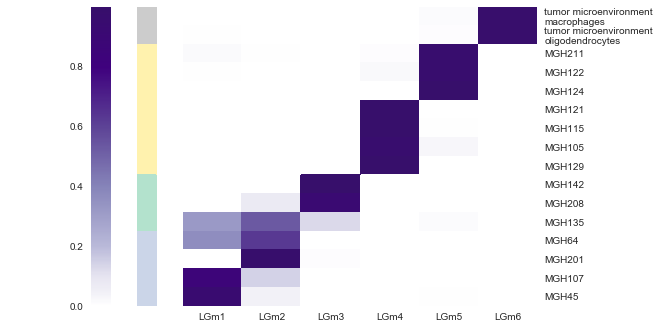

In [45]:
'Evaluate log_reg_l1 on pseudobulk'

# Predict pb Y
x_axis_labels = ['LGm1', 'LGm2', 'LGm3', 'LGm4', 'LGm5', 'LGm6']
Y_pb_pred = logisticRegr.predict_proba(X_pb_w_nonmalignant_impute)
plot_pb_classifier_results = pd.DataFrame(Y_pb_pred)
plot_pb_classifier_results.columns = x_axis_labels

# Attach the real pb genomic type, tumor name
Y_pd_genomictype = pd.DataFrame(Y_pb_w_nonmalignant)[0].map(classifier_dict)
plot_pb_classifier_results['genomic type'] = Y_pd_genomictype
plot_pb_classifier_results['tumor name'] = Y_pb_w_nonmalignant

# Prepare for plotting (Hot encode genomic type for plotting, sort tumors and attach tumor name)
Y_pd_order = pd.DataFrame(Y_pb_w_nonmalignant)[0].map(order_dict)
plot_pb_classifier_results['order'] = Y_pd_order

plot_pb_classifier_results['HO_genomic_type'] = LabelEncoder().fit_transform(plot_pb_classifier_results['genomic type'])
plot_pb_classifier_results.sort_values('order', inplace=True)
plot_pb_classifier_results.loc[plot_pb_classifier_results['tumor name'] == 'oligodendrocytes','tumor name'] = 'tumor microenvironment\noligodendrocytes'
plot_pb_classifier_results.loc[plot_pb_classifier_results['tumor name'] == 'macrophages','tumor name'] = 'tumor microenvironment\nmacrophages'

plot_pb_classifier_results.index = plot_pb_classifier_results['tumor name']


#Now add a plot for each sig

plt.style.use('seaborn')


fig, axs = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [0.5,0.5,9]})
sns.heatmap(
    plot_pb_classifier_results[x_axis_labels],
    cbar=False, 
    yticklabels=True,
    cmap=cm,
    xticklabels=x_axis_labels,
    ax=axs[len(axs) - 1], 
);

sns.heatmap(plot_pb_classifier_results[['HO_genomic_type']], cbar=False, cmap=plt.cm.get_cmap('Pastel2', 4), ax=axs[1], xticklabels=['real genomic type'])

def plot_sig(sig, ax, remove_tumors):
    pb_sig_dict = rna_scores.groupby('tumor').mean()[sig].to_dict()
    plot_pb_classifier_results[sig] = plot_pb_classifier_results['tumor name'].map(pb_sig_dict)
    plot_pb_classifier_results.loc[plot_pb_classifier_results.index.isin(remove_tumors),sig] = np.NaN
    sns.heatmap(plot_pb_classifier_results[[sig]], cbar=False, cmap='PiYG', ax=ax, xticklabels=[sig])
    ax.axis('off');


axs[1].axis('off');

# colorbar
fig.colorbar(axs[len(axs) - 1].get_children()[0], cax=axs[0])
axs[0].yaxis.tick_left()
axs[len(axs) - 1].set_yticklabels(axs[len(axs) - 1].get_yticklabels(), rotation = 0)
axs[len(axs) - 1].yaxis.tick_right()
axs[len(axs) - 1].set_ylabel("")
fig.savefig(figures_dir + "fig1_h_purples.pdf", bbox_inches='tight')


## Test classifier on single cells

In [46]:
df_sc_w_nonmalignant

rrbs_group,76573,87142,124135,152194,172900,176704,179663,195978,196724,213080,...,IDH_macrophage,IDH_normal,oligodendrocytes,macrophages,non_malignant,filename,tumor,y,original_tumor,original_tumor_sep_to_CD45
corrected_filename,,,,,,,,,,,,,,,,,,,,,
GBM_MGH105C_A1_S1_L008.ACAACC,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,...,False,False,False,False,False,MGH105C_A1_S1_L008.ACAACC,MGH105,WT,MGH105,MGH105
GBM_MGH105C_A1_S1_L008.ACAGAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,MGH105C_A1_S1_L008.ACAGAC,MGH105,WT,MGH105,MGH105
GBM_MGH105C_A1_S1_L008.ACTCAC,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,0.0,100.0,NaN,...,False,False,False,False,False,MGH105C_A1_S1_L008.ACTCAC,MGH105,WT,MGH105,MGH105
GBM_MGH105C_A1_S1_L008.AGAAGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,MGH105C_A1_S1_L008.AGAAGG,MGH105,WT,MGH105,MGH105
GBM_MGH105C_A1_S1_L008.AGGATG,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,False,False,False,False,False,MGH105C_A1_S1_L008.AGGATG,MGH105,WT,MGH105,MGH105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGH211_G1_S4_L008.ACAGAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,100.0,NaN,...,False,False,False,False,False,MGH211_G1_S4_L008.ACAGAC,MGH211,WT,MGH211,MGH211
MGH211_G1_S4_L008.TATCTC,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,MGH211_G1_S4_L008.TATCTC,MGH211,WT,MGH211,MGH211
MGH211_G1_S4_L008.TCTCTG,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,83.333333,...,False,False,False,False,False,MGH211_G1_S4_L008.TCTCTG,MGH211,WT,MGH211,MGH211


In [47]:
Y_filename = df_sc_w_nonmalignant['filename']
df_sc_w_nonmalignant = df_sc_w_nonmalignant.drop('filename', axis=1)

In [48]:
# read dna signatures from all rrbs
dict_from_all_rrbs = pd.read_table(resources_dir + "dna_mean_w_new_sigs.csv", sep = ",")

sc_filename = dict_from_all_rrbs['filename']
filenames = [filename.rstrip(".R1.fastq_bismark_bt2_pe.bismark.tsv") for filename in sc_filename]
filenames = [filename.rstrip(".R1.fastq_bismark_bt2_pe.bismark.cov") for filename in filenames]
filenames = [filename.replace('__001',"") for filename in filenames]
filenames = [filename.replace('-',"_") for filename in filenames]
filenames = [filename.replace('_.',".") for filename in filenames]
filenames = [filename.replace('MGH115_CD45',"MGH115") for filename in filenames]
dict_from_all_rrbs['filename'] = filenames

dict_from_all_rrbs.index = dict_from_all_rrbs['filename']

# prepare dictionaries from filename (cell) to all rrbs signature
dict_from_all_rrbs_to_all_tiles = dict_from_all_rrbs['all_tiles']
dict_from_all_rrbs_to_prc2targets = dict_from_all_rrbs['prc2targets']
dict_from_all_rrbs_to_chr6_tiles = dict_from_all_rrbs['chr6_tiles']
dict_from_all_rrbs_to_hk_tiles = dict_from_all_rrbs['HK_tiles']
dict_from_all_rrbs_to_HALLMARK_P53_PATHWAY_tiles = dict_from_all_rrbs['HALLMARK_P53_PATHWAY_tiles']
dict_from_all_rrbs_to_KEGG_P53_SIGNALING_PATHWAY_tiles = dict_from_all_rrbs['KEGG_P53_SIGNALING_PATHWAY_tiles']
dict_from_all_rrbs_to_PEREZ_TP53_AND_TP63_TARGETS_tiles = dict_from_all_rrbs['PEREZ_TP53_AND_TP63_TARGETS_tiles']
dict_from_all_rrbs_to_PID_P53_DOWNSTREAM_PATHWAY_tiles = dict_from_all_rrbs['PID_P53_DOWNSTREAM_PATHWAY_tiles']
dict_from_all_rrbs_coverage = dict_from_all_rrbs['coverage']


In [49]:
dict_from_all_rrbs.drop(columns = "Unnamed: 0", inplace=True)

In [50]:
'match meta data to the sc data'
Y_mean_meth_sc = df_sc_w_nonmalignant[rrbs_windows].mean(axis = 1)
Y_sc = df_sc_w_nonmalignant['tumor']
Y_original_tumor_sc = df_sc_w_nonmalignant['original_tumor']
Y_CpG_Sites_sc = df_sc_w_nonmalignant['CpG_Sites']
Y_Total_Reads_sc = df_sc_w_nonmalignant['Total_Reads']
Y_CG_conversion_rate_sc = df_sc_w_nonmalignant['CG_conversion_rate']
Y_oligodendrocytes_sc = df_sc_w_nonmalignant['oligodendrocytes']
Y_macrophages_sc = df_sc_w_nonmalignant['macrophages']
Y_coverage_sc = (~df_sc_w_nonmalignant[rrbs_windows].isnull()).sum(axis = 1)
NM_sc = df_sc_w_nonmalignant['non_malignant']
# Map from filename (cell) to all rrbs signature
Y_all_rrbs_to_all_tiles = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_to_all_tiles)
Y_all_rrbs_to_prc2targets = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_to_prc2targets)
Y_all_rrbs_to_chr6_tiles = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_to_chr6_tiles)
Y_all_rrbs_to_hk_tiles = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_to_hk_tiles)
Y_all_rrbs_to_HALLMARK_P53_PATHWAY_tiles = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_to_HALLMARK_P53_PATHWAY_tiles)
Y_all_rrbs_to_KEGG_P53_SIGNALING_PATHWAY_tiles = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_to_KEGG_P53_SIGNALING_PATHWAY_tiles)
Y_all_rrbs_to_PEREZ_TP53_AND_TP63_TARGETS_tiles = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_to_PEREZ_TP53_AND_TP63_TARGETS_tiles)
Y_all_rrbs_to_PID_P53_DOWNSTREAM_PATHWAY_tiles = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_to_PID_P53_DOWNSTREAM_PATHWAY_tiles)
Y_all_rrbs_to_coverage = df_sc_w_nonmalignant['qc_filename'].map(dict_from_all_rrbs_coverage)


In [51]:
'match sc data to the bulk training cases'
sc_zscore = copy.deepcopy(df_sc_w_nonmalignant)
sc_zscore = sc_zscore[df_data.columns]

In [52]:
sc_zscore = sc_zscore/100

In [53]:
sc_zcore_imputed = StandardScaler().fit_transform(sc_zscore)

In [54]:
sc_zcore_imputed = KNN(k=4).fit_transform(sc_zcore_imputed)

Imputing row 1/1423 with 793 missing, elapsed time: 17.305
Imputing row 101/1423 with 711 missing, elapsed time: 18.837
Imputing row 201/1423 with 727 missing, elapsed time: 20.916
Imputing row 301/1423 with 546 missing, elapsed time: 23.027
Imputing row 401/1423 with 799 missing, elapsed time: 24.852
Imputing row 501/1423 with 657 missing, elapsed time: 26.778
Imputing row 601/1423 with 597 missing, elapsed time: 28.393
Imputing row 701/1423 with 281 missing, elapsed time: 30.121
Imputing row 801/1423 with 739 missing, elapsed time: 31.188
Imputing row 901/1423 with 667 missing, elapsed time: 32.616
Imputing row 1001/1423 with 621 missing, elapsed time: 34.277
Imputing row 1101/1423 with 863 missing, elapsed time: 36.201
Imputing row 1201/1423 with 970 missing, elapsed time: 38.439
Imputing row 1301/1423 with 955 missing, elapsed time: 40.764
Imputing row 1401/1423 with 475 missing, elapsed time: 42.562


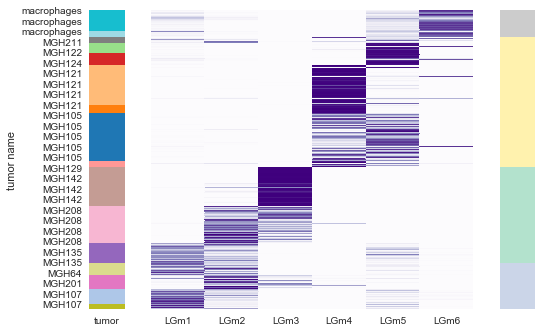

In [55]:
'Evaluate log_reg_l1 on pseudobulk'

# Predict pb Y
x_axis_labels = ['LGm1', 'LGm2', 'LGm3', 'LGm4', 'LGm5', 'LGm6']
Y_sc_pred = logisticRegr.predict_proba(sc_zcore_imputed)
plot_sc_classifier_results = pd.DataFrame(Y_sc_pred)
plot_sc_classifier_results.columns = x_axis_labels

# Attach the real pb genomic type, tumor name
Y_sc_genomictype = pd.DataFrame(Y_sc)['tumor'].map(classifier_dict)
plot_sc_classifier_results['genomic type'] = Y_sc_genomictype.values
plot_sc_classifier_results['filename'] = Y_filename.values
plot_sc_classifier_results['tumor name'] = Y_sc.values
plot_sc_classifier_results['original_tumor'] = Y_original_tumor_sc.values
plot_sc_classifier_results['non malignant'] = NM_sc.values
plot_sc_classifier_results['coverage'] = Y_coverage_sc.values
plot_sc_classifier_results['G-CIMP'] = Y_mean_meth_sc.values
plot_sc_classifier_results['CpG_Sites'] = Y_CpG_Sites_sc.values
plot_sc_classifier_results['Total_Reads'] = Y_Total_Reads_sc.values
plot_sc_classifier_results['CG_conversion_rate'] = Y_CG_conversion_rate_sc.values
plot_sc_classifier_results['all_rrbs_prc2targets_dna'] = Y_all_rrbs_to_prc2targets.values
plot_sc_classifier_results['all_rrbs_hk_dna'] = Y_all_rrbs_to_hk_tiles.values
Y_all_rrbs_to_coverage

# Prepare for plotting (Hot encode genomic type for plotting, sort tumors and attach tumor name)
Y_sc_order = pd.DataFrame(Y_sc)['tumor'].map(order_dict)
plot_sc_classifier_results['order'] = Y_sc_order.values
plot_sc_classifier_results['HO_genomic_type'] = LabelEncoder().fit_transform(plot_sc_classifier_results['genomic type'])
plot_sc_classifier_results['HO_tumor_name'] = LabelEncoder().fit_transform(plot_sc_classifier_results['tumor name'])
plot_sc_classifier_results.sort_values('order', inplace=True)
plot_sc_classifier_results.index = plot_sc_classifier_results['tumor name']


plt.style.use('seaborn')

fig, axs = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [1,9,1]})
sns.heatmap(plot_sc_classifier_results[['HO_tumor_name']], cbar=False, cmap=plt.cm.get_cmap('tab20', 19), ax=axs[0], xticklabels=['tumor'])
sns.heatmap(
    plot_sc_classifier_results[x_axis_labels],
    cbar=False, 
    yticklabels=False,
    cmap='Purples',
    xticklabels=x_axis_labels,
    ax=axs[1]
);
sns.heatmap(plot_sc_classifier_results[['HO_genomic_type']], yticklabels=False,cbar=False, cmap=plt.cm.get_cmap('Pastel2', 4), ax=axs[2], xticklabels=['real genomic type'])

axs[1].axes.get_yaxis().set_visible(False)
axs[2].axes.get_xaxis().set_visible(False)
axs[2].axes.get_yaxis().set_visible(False)
fig.savefig(figures_dir + "classifier_results_on_single_cells.pdf", bbox_inches='tight')
